In [13]:
from tabrepo import load_repository, EvaluationRepository, get_context
from collections import Counter

In [14]:
context_name = "D244_F3_C1530_100"
repo: EvaluationRepository = load_repository(context_name, cache=True)
context = get_context(name=context_name)
all_config_hyperparameters = context.load_configs_hyperparameters()
datasets = repo.datasets()
configs = repo.configs()
folds = repo.folds

repo.print_info()
print(datasets)
print(configs)
print(folds)

====== Zeroshot Simulator Context Info ======
# Configs: 1530
# Datasets: 100
# Folds: 3
Folds: [0, 1, 2]
# Folds*Datasets: 300

['Australian', 'Bioresponse', 'GAMETES_Epistasis_2-Way_1000atts_0_4H_EDM-1_EDM-1_1', 'GAMETES_Epistasis_2-Way_20atts_0_1H_EDM-1_1', 'GAMETES_Epistasis_2-Way_20atts_0_4H_EDM-1_1', 'GAMETES_Epistasis_3-Way_20atts_0_2H_EDM-1_1', 'GAMETES_Heterogeneity_20atts_1600_Het_0_4_0_2_50_EDM-2_001', 'GAMETES_Heterogeneity_20atts_1600_Het_0_4_0_2_75_EDM-2_001', 'Internet-Advertisements', 'LED-display-domain-7digit', 'MIP-2016-regression', 'Mercedes_Benz_Greener_Manufacturing', 'MiceProtein', 'Moneyball', 'OVA_Colon', 'OVA_Endometrium', 'OVA_Kidney', 'OVA_Lung', 'OVA_Ovary', 'OVA_Prostate', 'SAT11-HAND-runtime-regression', 'Titanic', 'UMIST_Faces_Cropped', 'abalone', 'analcatdata_authorship', 'analcatdata_dmft', 'arcene', 'arsenic-female-bladder', 'autoUniv-au1-1000', 'autoUniv-au6-750', 'autoUniv-au7-1100', 'autoUniv-au7-700', 'balance-scale', 'baseball', 'blood-transfusio

In [15]:
problem_types = []
for ds in datasets:
    dataset_info = repo.dataset_info(dataset=ds)
    problem_types.append(dataset_info['problem_type'])
    
Counter(problem_types)

Counter({'binary': 58, 'multiclass': 25, 'regression': 17})

In [16]:
num_classes_list = []
for ds in datasets:
    dataset_info = repo.dataset_info(dataset=ds)
    if dataset_info['problem_type'] == 'multiclass':
        dataset_metadata = repo.dataset_metadata(dataset=ds)
        num_classes_list.append(dataset_metadata['NumberOfClasses'])

print(dataset_metadata.keys())
Counter(num_classes_list)

dict_keys(['dataset', 'tid', 'ttid', 'did', 'name', 'task_type', 'status', 'estimation_procedure', 'evaluation_measures', 'source_data', 'target_feature', 'MajorityClassSize', 'MaxNominalAttDistinctValues', 'MinorityClassSize', 'NumberOfClasses', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfInstancesWithMissingValues', 'NumberOfMissingValues', 'NumberOfNumericFeatures', 'NumberOfSymbolicFeatures', 'number_samples', 'cost_matrix', 'source_data_labeled', 'target_feature_event', 'target_feature_left', 'target_feature_right', 'quality_measure', 'target_value'])


Counter({5.0: 6,
         3.0: 6,
         4.0: 3,
         6.0: 3,
         8.0: 2,
         20.0: 2,
         10.0: 1,
         9.0: 1,
         19.0: 1})

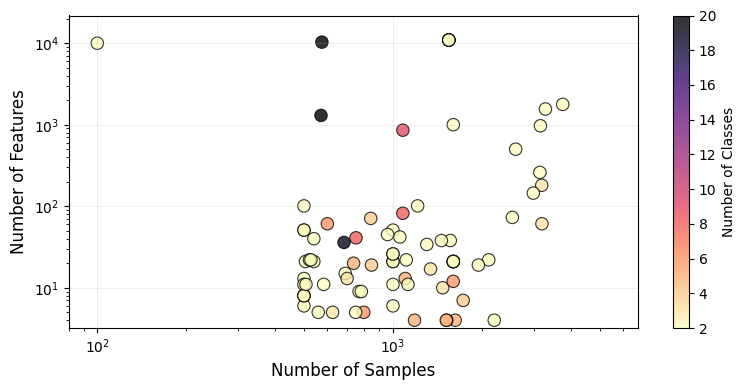

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Collect metadata for all datasets
all_datasets_metadata = []
for ds in datasets:
    dataset_info = repo.dataset_info(dataset=ds)
    problem_type = dataset_info.get('problem_type')
    # We only focus on classification datasets
    if problem_type in ['binary', 'multiclass']:
        dataset_metadata = repo.dataset_metadata(dataset=ds)
        all_datasets_metadata.append({
            'dataset': ds,
            'problem_type': problem_type,
            'n_samples': dataset_metadata.get('NumberOfInstances'),
            'n_features': dataset_metadata.get('NumberOfFeatures'),
            'n_classes': dataset_metadata.get('NumberOfClasses'),
        })

# Create a DataFrame from the collected metadata
cls_df = pd.DataFrame(all_datasets_metadata)

# Remove rows with NaN values
clean_data = cls_df.dropna(subset=['n_samples', 'n_features', 'n_classes'])

# Create the figure
plt.figure(figsize=(8, 4))

# Create the scatter plot with better visibility
scatter = plt.scatter(clean_data['n_samples'], clean_data['n_features'], 
                     c=clean_data['n_classes'], cmap='magma_r',
                     alpha=0.8, s=80, edgecolors='black', linewidth=0.8)

# Set axis limits to focus on the main cluster of data (excluding extreme outliers)
x_percentile_99 = np.percentile(clean_data['n_samples'], 99)
y_percentile_99 = np.percentile(clean_data['n_features'], 99)

plt.xlim(clean_data['n_samples'].min() * 0.8, x_percentile_99 * 2)
plt.ylim(clean_data['n_features'].min() * 0.8, y_percentile_99 * 2)

# Set log scales
plt.xscale('log')
plt.yscale('log')

# Add colorbar
cbar = plt.colorbar(scatter, label='Number of Classes')
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)}'))

# Labels and title
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Number of Features', fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Add some statistics as text
n_datasets = len(clean_data)
min_samples = clean_data['n_samples'].min()
max_samples = clean_data['n_samples'].max()
min_features = clean_data['n_features'].min()
max_features = clean_data['n_features'].max()
min_classes = clean_data['n_classes'].min()
max_classes = clean_data['n_classes'].max()

# Adjust layout and show
plt.tight_layout()
plt.savefig("../plots/tabrepo-datasets.pdf", dpi=300)
plt.savefig("../plots/tabrepo-datasets.png", dpi=300)
plt.show()
